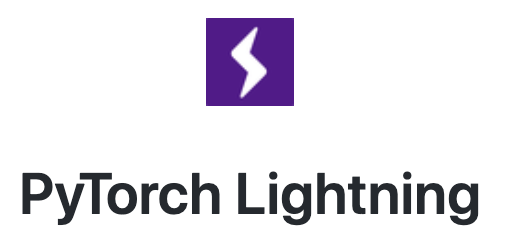

# Lit BERT tutorial

This tutorial shows how to use [Huggingface BERT](https://github.com/huggingface/transformers) with [Lightning](https://github.com/williamFalcon/pytorch-lightning/).

BERT is a model developed by Google-research [(Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova, 2018).](https://arxiv.org/abs/1810.04805)

## Setup  
Lightning is easy to use. Simply ```pip install pytorch-lightning```

In [ ]:
! pip install pytorch-lightning

Install the transformers library from our friends over at Huggingface

In [ ]:
! pip install transformers

## Data download + processing

Let's grab the correct data. The most time consuming part of setting up the transfer learning problem is the data processing!

In [ ]:
from transformers.data.processors.glue import MnliProcessor
import torch
from transformers import (
    BertModel,
    BertTokenizer
)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert = BertModel.from_pretrained('bert-base-cased', output_attentions=True)

100%|██████████| 435779157/435779157 [00:37<00:00, 11496752.07B/s]


In [ ]:
import pandas as pd
import os
import sys
import shutil
import argparse
import tempfile
import urllib.request
import zipfile

TASKS = ["CoLA", "SST", "MRPC", "QQP", "STS", "MNLI", "SNLI", "QNLI", "RTE", "WNLI", "diagnostic"]
TASK2PATH = {
    "CoLA": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FCoLA.zip?alt=media&token=46d5e637-3411-4188-bc44-5809b5bfb5f4",  # noqa
    "SST": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSST-2.zip?alt=media&token=aabc5f6b-e466-44a2-b9b4-cf6337f84ac8",  # noqa
    "MRPC": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc",  # noqa
    "QQP": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQQP-clean.zip?alt=media&token=11a647cb-ecd3-49c9-9d31-79f8ca8fe277",  # noqa
    "STS": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSTS-B.zip?alt=media&token=bddb94a7-8706-4e0d-a694-1109e12273b5",  # noqa
    "MNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FMNLI.zip?alt=media&token=50329ea1-e339-40e2-809c-10c40afff3ce",  # noqa
    "SNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSNLI.zip?alt=media&token=4afcfbb2-ff0c-4b2d-a09a-dbf07926f4df",  # noqa
    "QNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQNLIv2.zip?alt=media&token=6fdcf570-0fc5-4631-8456-9505272d1601",  # noqa
    "RTE": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FRTE.zip?alt=media&token=5efa7e85-a0bb-4f19-8ea2-9e1840f077fb",  # noqa
    "WNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FWNLI.zip?alt=media&token=068ad0a0-ded7-4bd7-99a5-5e00222e0faf",  # noqa
    "diagnostic": [
        "https://storage.googleapis.com/mtl-sentence-representations.appspot.com/tsvsWithoutLabels%2FAX.tsv?GoogleAccessId=firebase-adminsdk-0khhl@mtl-sentence-representations.iam.gserviceaccount.com&Expires=2498860800&Signature=DuQ2CSPt2Yfre0C%2BiISrVYrIFaZH1Lc7hBVZDD4ZyR7fZYOMNOUGpi8QxBmTNOrNPjR3z1cggo7WXFfrgECP6FBJSsURv8Ybrue8Ypt%2FTPxbuJ0Xc2FhDi%2BarnecCBFO77RSbfuz%2Bs95hRrYhTnByqu3U%2FYZPaj3tZt5QdfpH2IUROY8LiBXoXS46LE%2FgOQc%2FKN%2BA9SoscRDYsnxHfG0IjXGwHN%2Bf88q6hOmAxeNPx6moDulUF6XMUAaXCSFU%2BnRO2RDL9CapWxj%2BDl7syNyHhB7987hZ80B%2FwFkQ3MEs8auvt5XW1%2Bd4aCU7ytgM69r8JDCwibfhZxpaa4gd50QXQ%3D%3D",  # noqa
        "https://www.dropbox.com/s/ju7d95ifb072q9f/diagnostic-full.tsv?dl=1",
    ],
}

MRPC_TRAIN = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt"
MRPC_TEST = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt"


def download_and_extract(task, data_dir):
    print("Downloading and extracting %s..." % task)
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print("\tCompleted!")

In [ ]:
download_and_extract('MNLI', '.')

	Completed!


In [ ]:
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, RandomSampler, DataLoader, random_split

processor = MnliProcessor()

#### Data loaders


In [ ]:
def generate_mnli_bert_dataloaders():
  # ----------------------
  # TRAIN/VAL DATALOADERS
  # ----------------------
  train = processor.get_train_examples('MNLI')
  features = convert_examples_to_features(train,
                                          tokenizer,
                                          label_list=['contradiction','neutral','entailment'],
                                          max_length=128,
                                          output_mode='classification',
                                          pad_on_left=False,
                                          pad_token=tokenizer.pad_token_id,
                                          pad_token_segment_id=0)
  train_dataset = TensorDataset(torch.tensor([f.input_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.attention_mask for f in features], dtype=torch.long), 
                                torch.tensor([f.token_type_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.label for f in features], dtype=torch.long))

  nb_train_samples = int(0.95 * len(train_dataset))
  nb_val_samples = len(train_dataset) - nb_train_samples

  bert_mnli_train_dataset, bert_mnli_val_dataset = random_split(train_dataset, [nb_train_samples, nb_val_samples])

  # train loader
  train_sampler = RandomSampler(bert_mnli_train_dataset)
  bert_mnli_train_dataloader = DataLoader(bert_mnli_train_dataset, sampler=train_sampler, batch_size=32)

  # val loader
  val_sampler = RandomSampler(bert_mnli_val_dataset)
  bert_mnli_val_dataloader = DataLoader(bert_mnli_val_dataset, sampler=val_sampler, batch_size=32)


  # ----------------------
  # TEST DATALOADERS
  # ----------------------
  dev = processor.get_dev_examples('MNLI')
  features = convert_examples_to_features(dev,
                                          tokenizer,
                                          label_list=['contradiction','neutral','entailment'],
                                          max_length=128,
                                          output_mode='classification',
                                          pad_on_left=False,
                                          pad_token=tokenizer.pad_token_id,
                                          pad_token_segment_id=0)

  bert_mnli_test_dataset = TensorDataset(torch.tensor([f.input_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.attention_mask for f in features], dtype=torch.long), 
                                torch.tensor([f.token_type_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.label for f in features], dtype=torch.long))

  # test dataset
  test_sampler = RandomSampler(bert_mnli_test_dataset)
  bert_mnli_test_dataloader = DataLoader(bert_mnli_test_dataset, sampler=test_sampler, batch_size=32)
  
  return bert_mnli_train_dataloader, bert_mnli_val_dataloader, bert_mnli_test_dataloader

In [ ]:
bert_mnli_train_dataloader, bert_mnli_val_dataloader, bert_mnli_test_dataloader = generate_mnli_bert_dataloaders()


### BERT Lightning module!

Finally, we can create the LightningModule

In [ ]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn


class BertMNLIFinetuner(pl.LightningModule):

    def __init__(self):
        super(BertMNLIFinetuner, self).__init__()
        
        self.bert = bert
        self.W = nn.Linear(bert.config.hidden_size, 3)
        self.num_classes = 3


    def forward(self, input_ids, attention_mask, token_type_ids):
      
        h, _, attn = self.bert(input_ids=input_ids, 
                         attention_mask=attention_mask, 
                         token_type_ids=token_type_ids)
        
        h_cls = h[:, 0]
        logits = self.W(h_cls)
        return logits, attn

    def training_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label = batch
         
        # fwd
        y_hat, attn = self.forward(input_ids, attention_mask, token_type_ids)
        
        # loss
        loss = F.cross_entropy(y_hat, label)
        
        # logs
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label = batch
         
        # fwd
        y_hat, attn = self.forward(input_ids, attention_mask, token_type_ids)
        
        # loss
        loss = F.cross_entropy(y_hat, label)
        
        # acc
        a, y_hat = torch.max(y_hat, dim=1)
        val_acc = accuracy_score(y_hat.cpu(), label.cpu())
        val_acc = torch.tensor(val_acc)

        return {'val_loss': loss, 'val_acc': val_acc}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss, 'avg_val_acc': avg_val_acc}
        return {'avg_val_loss': avg_loss, 'progress_bar': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        input_ids, attention_mask, token_type_ids, label = batch
        
        y_hat, attn = self.forward(input_ids, attention_mask, token_type_ids)
        
        a, y_hat = torch.max(y_hat, dim=1)
        test_acc = accuracy_score(y_hat.cpu(), label.cpu())
        
        return {'test_acc': torch.tensor(test_acc)}

    def test_end(self, outputs):

        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()

        tensorboard_logs = {'avg_test_acc': avg_test_acc}
        return {'avg_test_acc': avg_test_acc, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)


    @pl.data_loader
    def train_dataloader(self):
        return bert_mnli_train_dataloader

    @pl.data_loader
    def val_dataloader(self):
        return bert_mnli_val_dataloader

    @pl.data_loader
    def test_dataloader(self):
        return bert_mnli_test_dataloader

### Trainer
The trainer takes care of putting things in the correct GPU or not.
It handles all the engineering for you (such as automatic early stopping) so you just have to worry about the model and data!

In [ ]:
bert_finetuner = BertMNLIFinetuner()

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1)    
trainer.fit(bert_finetuner) 

## Summary

That's it! Checkout [PyTorch Lightning](https://github.com/williamFalcon/pytorch-lightning/) which works with any machine learning approach that uses PyTorch.